In [1]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
from torch_scatter import segment_coo
from sklearn.datasets import make_blobs
import itertools
from layers.ect import EctLayer
from layers.config import EctConfig
import time
from torch_geometric.data import Data, Batch
from torch_geometric.datasets.graph_generator import GraphGenerator
from torch_geometric.utils import barabasi_albert_graph
import torch.nn.functional as F
from datasets.mnist import EctMnistDataModule

# from datasets.transforms import EctTransform
from datasets.config import MnistDataModuleConfig


NUM_PTS = 5

# Device
CUDA_DEVICE_NUM = 0
DEVICE = torch.device(f'cuda:{CUDA_DEVICE_NUM}' if torch.cuda.is_available() else 'cpu')
# DEVICE = 'cuda:0'
print('Device:', DEVICE)

# Hyperparameters
RANDOM_SEED = 123
LEARNING_RATE = 1e-4
BATCH_SIZE = 128
NUM_EPOCHS = 10



Device: cuda:0


In [2]:
dataset = EctMnistDataModule(MnistDataModuleConfig())

data = dataset.entire_ds[0]

for batch in dataset.train_dataloader():
    break
batch.to(DEVICE)

DataBatch(x=[64, 32, 32], pts=[2078, 2], batch=[64], ptr=[65])

tensor(1.)


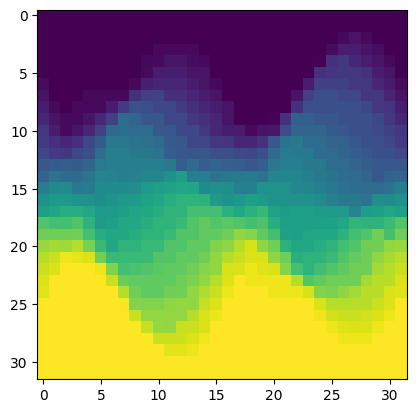

In [3]:
print(data.x.max())

plt.imshow(data.x.squeeze())


In [4]:

class Reshape(nn.Module):
    def __init__(self, *args):
        super().__init__()
        self.shape = args

    def forward(self, x):
        return x.view(self.shape)


class Trim(nn.Module):
    def __init__(self, *args):
        super().__init__()

    def forward(self, x):
        return x[:, :, :32, :32]
    

class VAE(nn.Module):
    def __init__(self):
        super().__init__()
        self.latent_size = 10
        
        self.encoder = nn.Sequential(
                nn.Conv2d(1, 32, stride=(1, 1), kernel_size=(3, 3), padding=1),
                nn.LeakyReLU(0.01),
                nn.Conv2d(32, 64, stride=(2, 2), kernel_size=(3, 3), padding=1),
                nn.LeakyReLU(0.01),
                nn.Conv2d(64, 64, stride=(2, 2), kernel_size=(3, 3), padding=1),
                nn.LeakyReLU(0.01),
                nn.Conv2d(64, 64, stride=(1, 1), kernel_size=(3, 3), padding=1),
                nn.Flatten(),
        )    
        
        self.z_mean = torch.nn.Linear(4096, self.latent_size)
        self.z_log_var = torch.nn.Linear(4096, self.latent_size)
        
        self.decoder = nn.Sequential(
                torch.nn.Linear(self.latent_size, 4096),
                Reshape(-1, 64, 8, 8),
                nn.ConvTranspose2d(64, 64, stride=(1, 1), kernel_size=(3, 3), padding=1),
                nn.LeakyReLU(0.01),
                nn.ConvTranspose2d(64, 64, stride=(2, 2), kernel_size=(3, 3), padding=1),                
                nn.LeakyReLU(0.01),
                nn.ConvTranspose2d(64, 32, stride=(2, 2), kernel_size=(3, 3), padding=0),                
                nn.LeakyReLU(0.01),
                nn.ConvTranspose2d(32, 1, stride=(1, 1), kernel_size=(3, 3), padding=0), 
                Trim(),  # 1x29x29 -> 1x28x28
                nn.Sigmoid()
                )

    def encoding_fn(self, x):
        x = self.encoder(x)
        z_mean, z_log_var = self.z_mean(x), self.z_log_var(x)
        encoded = self.reparameterize(z_mean, z_log_var)
        return encoded
        
    def reparameterize(self, z_mu, z_log_var):
        eps = torch.randn(z_mu.size(0), z_mu.size(1)).to(z_mu.device)
        z = z_mu + eps * torch.exp(z_log_var/2.) 
        return z
        
    def forward(self, x):
        x = self.encoder(x)
        z_mean, z_log_var = self.z_mean(x), self.z_log_var(x)
        encoded = self.reparameterize(z_mean, z_log_var)
        decoded = self.decoder(encoded)
        return encoded, z_mean, z_log_var, decoded
    
"""
For testing the model.
"""

model = VAE()
model.to(DEVICE)
encoded, z_mean, z_log_var, decoded = model(batch.x.unsqueeze(1))
print(decoded.shape)

torch.Size([64, 1, 32, 32])


In [5]:
model = VAE()
model.to(DEVICE)
criterion = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)


In [6]:
def compute_epoch_loss_autoencoder(model, data_loader, loss_fn, device):
    model.eval()
    curr_loss, num_examples = 0., 0
    with torch.no_grad():
        for features, _ in data_loader:
            features = features.to(device)
            logits = model(features)
            loss = loss_fn(logits, features, reduction='sum')
            num_examples += features.size(0)
            curr_loss += loss

        curr_loss = curr_loss / num_examples
        return curr_loss


def train_vae_v1(num_epochs, model, optimizer, device, 
                 train_loader, loss_fn=None,
                 logging_interval=100, 
                 skip_epoch_stats=False,
                 reconstruction_term_weight=.5,
                 save_model=None):
    
    log_dict = {'train_combined_loss_per_batch': [],
                'train_combined_loss_per_epoch': [],
                'train_reconstruction_loss_per_batch': [],
                'train_kl_loss_per_batch': []}

    if loss_fn is None:
        loss_fn = F.mse_loss

    start_time = time.time()
    for epoch in range(num_epochs):

        model.train()
        for batch_idx, features in enumerate(train_loader):

            features = features.x.to(device)

            # FORWARD AND BACK PROP
            encoded, z_mean, z_log_var, decoded = model(features.unsqueeze(1))
            
            # total loss = reconstruction loss + KL divergence
            #kl_divergence = (0.5 * (z_mean**2 + 
            #                        torch.exp(z_log_var) - z_log_var - 1)).sum()
            kl_div = -0.5 * torch.sum(1 + z_log_var 
                                      - z_mean**2 
                                      - torch.exp(z_log_var), 
                                      axis=1) # sum over latent dimension

            batchsize = kl_div.size(0)
            kl_div = kl_div.mean() # average over batch dimension
    
            pixelwise = loss_fn(decoded, features, reduction='none')
            pixelwise = pixelwise.view(batchsize, -1).sum(axis=1) # sum over pixels
            pixelwise = pixelwise.mean() # average over batch dimension
            
            loss = reconstruction_term_weight*pixelwise + kl_div
            
            optimizer.zero_grad()

            loss.backward()

            # UPDATE MODEL PARAMETERS
            optimizer.step()

            # LOGGING
            log_dict['train_combined_loss_per_batch'].append(loss.item())
            log_dict['train_reconstruction_loss_per_batch'].append(pixelwise.item())
            log_dict['train_kl_loss_per_batch'].append(kl_div.item())
            
            if not batch_idx % logging_interval:
                print('Epoch: %03d/%03d | Batch %04d/%04d | Loss: %.4f'
                      % (epoch+1, num_epochs, batch_idx,
                          len(train_loader), loss))

        if not skip_epoch_stats:
            model.eval()
            
            with torch.set_grad_enabled(False):  # save memory during inference
                
                train_loss = compute_epoch_loss_autoencoder(
                    model, train_loader, loss_fn, device)
                print('***Epoch: %03d/%03d | Loss: %.3f' % (
                      epoch+1, num_epochs, train_loss))
                log_dict['train_combined_per_epoch'].append(train_loss.item())

        print('Time elapsed: %.2f min' % ((time.time() - start_time)/60))
    
    print('Total Training Time: %.2f min' % ((time.time() - start_time)/60))
    if save_model is not None:
        torch.save(model.state_dict(), save_model)
    
    return log_dict

In [7]:
train_loader = dataset.train_dataloader()

log_dict = train_vae_v1(num_epochs=NUM_EPOCHS, model=model, 
                        optimizer=optimizer, device=DEVICE, 
                        train_loader=train_loader,
                        skip_epoch_stats=True,
                        logging_interval=50)

C:\Users\ernst\AppData\Local\Temp\ipykernel_17340\2709948971.py:53: UserWarning: Using a target size (torch.Size([64, 32, 32])) that is different to the input size (torch.Size([64, 1, 32, 32])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  pixelwise = loss_fn(decoded, features, reduction='none')


Epoch: 001/010 | Batch 0000/0844 | Loss: 4692.7656
Epoch: 001/010 | Batch 0050/0844 | Loss: 1099.9821
Epoch: 001/010 | Batch 0100/0844 | Loss: 356.5667
Epoch: 001/010 | Batch 0150/0844 | Loss: 243.4991
Epoch: 001/010 | Batch 0200/0844 | Loss: 206.4487
Epoch: 001/010 | Batch 0250/0844 | Loss: 188.2489
Epoch: 001/010 | Batch 0300/0844 | Loss: 179.1659
Epoch: 001/010 | Batch 0350/0844 | Loss: 166.4340
Epoch: 001/010 | Batch 0400/0844 | Loss: 160.7695
Epoch: 001/010 | Batch 0450/0844 | Loss: 179.0044
Epoch: 001/010 | Batch 0500/0844 | Loss: 164.0515
Epoch: 001/010 | Batch 0550/0844 | Loss: 154.0442
Epoch: 001/010 | Batch 0600/0844 | Loss: 160.1748
Epoch: 001/010 | Batch 0650/0844 | Loss: 165.1346
Epoch: 001/010 | Batch 0700/0844 | Loss: 140.6407
Epoch: 001/010 | Batch 0750/0844 | Loss: 146.1881
Epoch: 001/010 | Batch 0800/0844 | Loss: 143.6793


C:\Users\ernst\AppData\Local\Temp\ipykernel_17340\2709948971.py:53: UserWarning: Using a target size (torch.Size([48, 32, 32])) that is different to the input size (torch.Size([48, 1, 32, 32])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  pixelwise = loss_fn(decoded, features, reduction='none')


Time elapsed: 0.11 min
Epoch: 002/010 | Batch 0000/0844 | Loss: 142.0778
Epoch: 002/010 | Batch 0050/0844 | Loss: 144.4154
Epoch: 002/010 | Batch 0100/0844 | Loss: 147.4250
Epoch: 002/010 | Batch 0150/0844 | Loss: 151.6588
Epoch: 002/010 | Batch 0200/0844 | Loss: 135.5047
Epoch: 002/010 | Batch 0250/0844 | Loss: 154.3657
Epoch: 002/010 | Batch 0300/0844 | Loss: 133.6802
Epoch: 002/010 | Batch 0350/0844 | Loss: 147.8567
Epoch: 002/010 | Batch 0400/0844 | Loss: 153.9482
Epoch: 002/010 | Batch 0450/0844 | Loss: 149.3607
Epoch: 002/010 | Batch 0500/0844 | Loss: 148.6212
Epoch: 002/010 | Batch 0550/0844 | Loss: 146.9846
Epoch: 002/010 | Batch 0600/0844 | Loss: 149.9402
Epoch: 002/010 | Batch 0650/0844 | Loss: 149.8071
Epoch: 002/010 | Batch 0700/0844 | Loss: 147.1053
Epoch: 002/010 | Batch 0750/0844 | Loss: 146.0028
Epoch: 002/010 | Batch 0800/0844 | Loss: 161.3200
Time elapsed: 0.19 min
Epoch: 003/010 | Batch 0000/0844 | Loss: 145.0518
Epoch: 003/010 | Batch 0050/0844 | Loss: 145.8599
Epoc

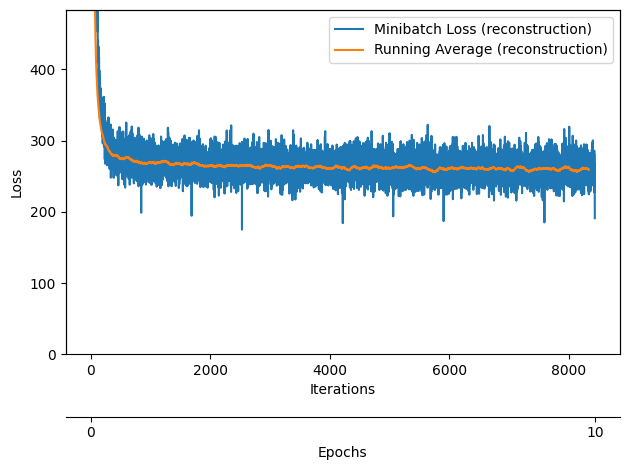

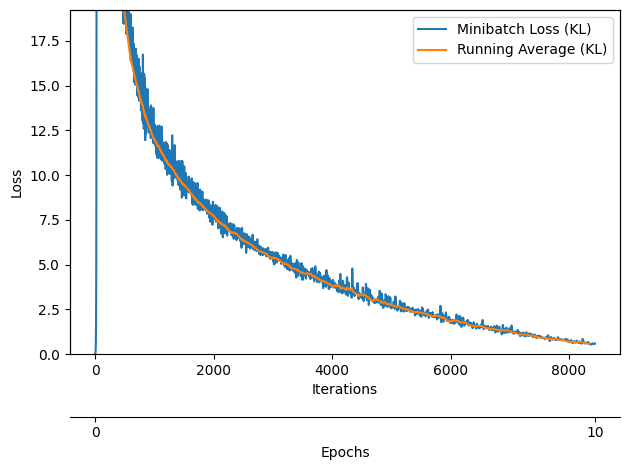

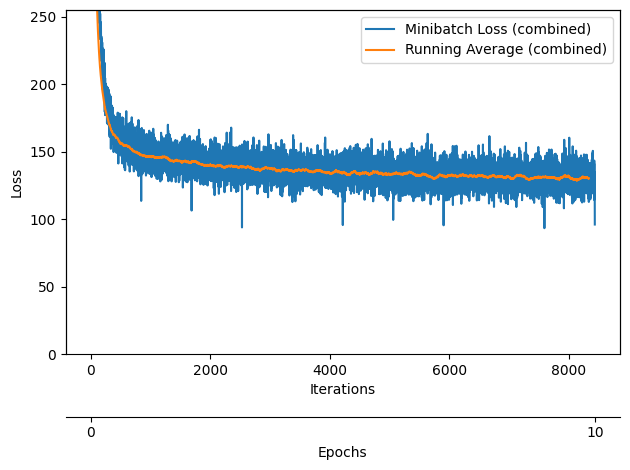

In [16]:
from notebooks.helper_plotting import plot_training_loss

plot_training_loss(log_dict['train_reconstruction_loss_per_batch'], NUM_EPOCHS, custom_label=" (reconstruction)")
plot_training_loss(log_dict['train_kl_loss_per_batch'], NUM_EPOCHS, custom_label=" (KL)")
plot_training_loss(log_dict['train_combined_loss_per_batch'], NUM_EPOCHS, custom_label=" (combined)")
plt.show()

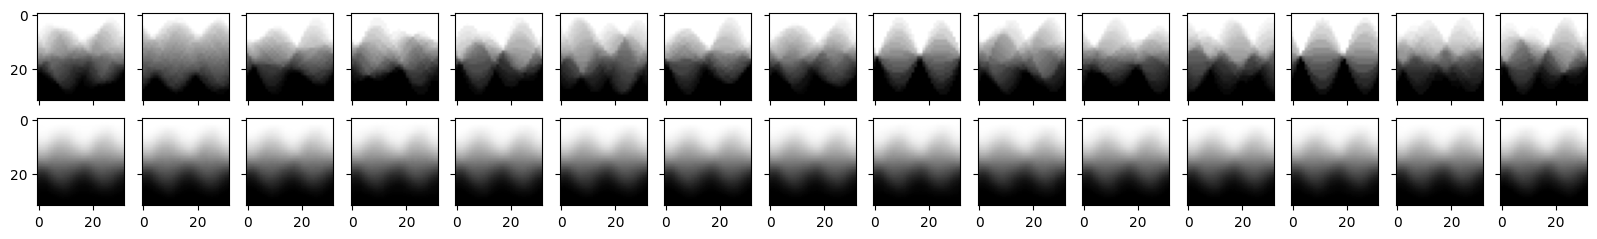

In [17]:
from notebooks.helper_plotting import plot_generated_images

plot_generated_images(data_loader=train_loader, model=model, device=DEVICE, modeltype='VAE')           

In [10]:
torch.save(model.state_dict(), "vae_model.pt")

In [18]:
def plot_images_sampled_from_vae_orig(model, device, latent_size, unnormalizer=None, num_images=10):

    with torch.no_grad():

        ##########################
        ### RANDOM SAMPLE
        ##########################    

        rand_features = .2*torch.randn(num_images, latent_size).to(device)
        new_images = model.decoder(rand_features)
        print(new_images.shape)
        color_channels = new_images.shape[1]
        image_height = new_images.shape[2]
        image_width = new_images.shape[3]

        ##########################
        ### VISUALIZATION
        ##########################

        image_width = 28

        fig, axes = plt.subplots(nrows=1, ncols=num_images, figsize=(10, 2.5), sharey=True)
        decoded_images = new_images[:num_images]

        for ax, img in zip(axes, decoded_images):
            curr_img = img.detach().to(torch.device('cpu'))        
            if unnormalizer is not None:
                curr_img = unnormalizer(curr_img)

            if color_channels > 1:
                curr_img = np.transpose(curr_img, (1, 2, 0))
                ax.imshow(curr_img)
            else:
                ax.imshow(curr_img.view((image_height, image_width)), cmap='binary') 


def plot_images_sampled_from_vae(model, device, latent_size, unnormalizer=None, num_images=10):

    with torch.no_grad():

        ##########################
        ### RANDOM SAMPLE
        ##########################    

        rand_features = torch.randn(num_images, latent_size).to(device)
        new_images = model.decoder(rand_features)
        color_channels = new_images.shape[1]
        image_height = new_images.shape[2]
        image_width = new_images.shape[3]

        ##########################
        ### VISUALIZATION
        ##########################

        image_width = 32

        fig, axes = plt.subplots(nrows=1, ncols=num_images, figsize=(10, 2.5), sharey=True)
        decoded_images = new_images[:num_images]

        for ax, img in zip(axes, decoded_images):
            curr_img = img.detach().to(torch.device('cpu'))        
            if unnormalizer is not None:
                curr_img = unnormalizer(curr_img)

            if color_channels > 1:
                curr_img = np.transpose(curr_img, (1, 2, 0))
                ax.imshow(curr_img)
            else:
                ax.imshow(curr_img.view((image_height, image_width)), cmap='binary') 

torch.Size([10, 1, 32, 32])


RuntimeError: shape '[32, 28]' is invalid for input of size 1024

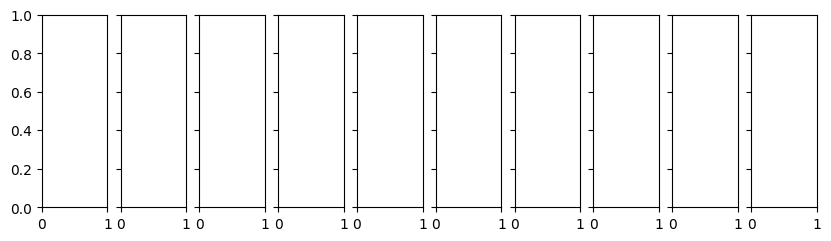

In [20]:
for i in range(1):
    plot_images_sampled_from_vae_orig(model=model, device=DEVICE, latent_size=10)
    plt.show()